In [429]:
import scipy.sparse as ss
import torch
import numpy as np
import os
import time
import cv2
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
import torchvision.transforms as transforms
import torch.optim as optim


In [411]:
%%timeit

F = np.random.rand(32*32)
X = np.random.rand(32*32)
width = 32
if type(F) != torch.Tensor:
        F = torch.from_numpy(F)
        X = torch.from_numpy(X)
F = F.unsqueeze(0).unsqueeze(0)
X = X.unsqueeze(0).unsqueeze(0)
with torch.no_grad():
    pixel_indices = [i for i in range(width * width)]
    pixel_indices = np.reshape(pixel_indices, (width, width))
    A = connected_adjacency(pixel_indices, connect='8')
    A_pair = np.asarray(np.where(A.toarray() == 1)).T

    def lambda_func(x):
        return get_w(x, F)

    W = list(map(lambda_func, A_pair))
    A = torch.zeros(F.shape[0], width ** 2, width ** 2).type(dtype)
    R = X.repeat(1, X.shape[2], 1).type(dtype)
    R = abs(R - R.permute(0, 2, 1) )

    for idx, p in enumerate(A_pair):
        # CAN SPEED UP THIS
        i = p[0]
        j = p[1]
        A[:, i, j] = W[idx]
    GTV = (R*A).sum()


312 ms ± 5.06 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


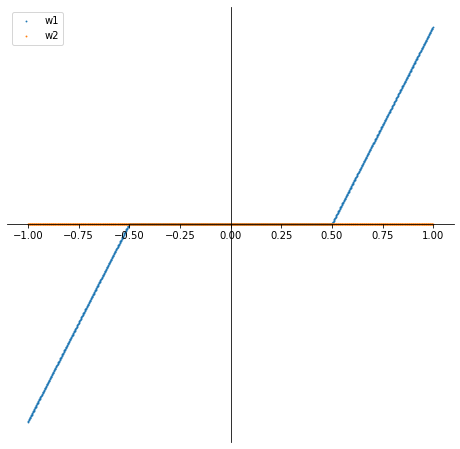

In [360]:
g = list()
rg = list()
idx = list()
for i in range(1000):
    d = (i - 500) / 500
    idx.append(d)
    eta=1
    w1 = 0.5 
    w2 = -0.5
    g.append(prox_gtv(w1, d, eta))
    rg.append(prox_gtv(w2, d, eta))
#     rg.append(np.exp(-(d*d)/(0.1**2))*d)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
plt.gca()
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.scatter(idx, g, label='w1', s=0.75)
ax.scatter(idx, rg, label='w2', s=0.75)
ax.legend()
ax.get_yaxis().set_visible(False)
# ax.get_xaxis().set_visible(False)

tensor([24.9750], dtype=torch.float64)


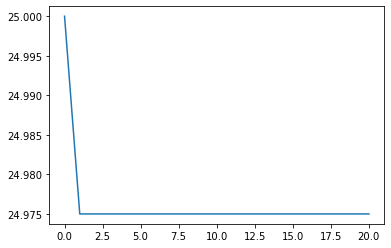

In [413]:
x = 25
steps = [x]
T = 20
a = np.array([25.0])
b = np.array([.05])
y = np.array([25.0])
w = torch.from_numpy(b)
v = torch.from_numpy(a)
y = torch.from_numpy(y)
for i in range(T):
    x = proximal_gradient_descent(x=v, y=y, w=w, eta=.5)
    steps.append(x)
print(x)
plt.plot(list(range(T+1)), steps)

In [613]:
cuda = True if torch.cuda.is_available() else False
if cuda:
    dtype = torch.cuda.FloatTensor
else:
    dtype = torch.FloatTensor


class cnnf(nn.Module):
    """
    CNN F of GLR
    """

    def __init__(self):
        super(cnnf, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        self.layer2a = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), nn.ReLU()
        )
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), nn.ReLU()
        )

        self.layer3a = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), nn.ReLU()
        )
        # self.maxpool
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), nn.ReLU()
        )
        # DECONVO

        self.deconvo1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.ReflectionPad2d(1),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=0),
        )

        # CONCAT with output of layer2
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        # DECONVO
        self.deconvo2 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=0),
        )

        # CONCAT with output of layer1
        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1),
        )
        self.relu = nn.ReLU()

    def forward(self, x):
        outl1 = self.layer1(x)
        outl2 = self.layer2a(outl1)
        outl2 = self.maxpool(outl2)
        outl2 = self.layer2(outl2)
        outl3 = self.layer3a(outl2)
        outl3 = self.maxpool(outl3)
        outl3 = self.layer3(outl3)
        outl3 = self.deconvo1(outl3)
        outl3 = torch.cat((outl3, outl2), dim=1)
        outl4 = self.layer4(outl3)
        outl4 = self.deconvo2(outl4)
        outl4 = torch.cat((outl4, outl1), dim=1)
        del outl1, outl2, outl3
        out = self.layer5(outl4)
        return out

class cnny(nn.Module):
    """
    CNN Y of GLR
    """

    def __init__(self):
        super(cnny, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1),
        )

    def forward(self, x):
        identity = x
        out = self.layer(x)
        out = identity + out
        del identity
        return out

class cnnp(nn.Module):
    """
    CNN Y of GLR
    """

    def __init__(self, wt=36):
        super(cnnp, self).__init__()
        self.wt = wt
        self.layer = nn.Sequential(
            torch.nn.Linear(self.wt**2, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 1),
            torch.nn.ReLU()
        )

    def forward(self, x):
        out = self.layer(x)
        return out
    
class RENOIR_Dataset(Dataset):
    """
    Dataset loader
    """

    def __init__(self, img_dir, transform=None):
        """
        Args:
            img_dir (string): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.img_dir = img_dir
        self.npath = os.path.join(img_dir, "noisy")
        self.rpath = os.path.join(img_dir, "ref")
        self.nimg_name = sorted(os.listdir(self.npath))
        self.rimg_name = sorted(os.listdir(self.rpath))
        self.nimg_name = [
            i
            for i in self.nimg_name
            if i.split(".")[-1].lower() in ["jpeg", "jpg", "png", "bmp"]
        ]
        self.rimg_name = [
            i
            for i in self.rimg_name
            if i.split(".")[-1].lower() in ["jpeg", "jpg", "png", "bmp"]
        ]
        self.transform = transform

    def __len__(self):
        return len(self.nimg_name)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        nimg_name = os.path.join(self.npath, self.nimg_name[idx])
        nimg = cv2.imread(nimg_name)
        rimg_name = os.path.join(self.rpath, self.rimg_name[idx])
        rimg = cv2.imread(rimg_name)

        sample = {"nimg": nimg, "rimg": rimg}

        if self.transform:
            sample = self.transform(sample)

        return sample


class standardize(object):
    """Convert opencv BGR to RGB order. Scale the image with a ratio"""

    def __init__(self, scale=None, w=None, normalize=None):
        """
        Args:
        scale (float): resize height and width of samples to scale*width and scale*height
        width (float): resize height and width of samples to width x width. Only works if "scale" is not specified
        """
        self.scale = scale
        self.w = w
        self.normalize = normalize

    def __call__(self, sample):
        nimg, rimg = sample["nimg"], sample["rimg"]
        if self.scale:
            nimg = cv2.resize(nimg, (0, 0), fx=self.scale, fy=self.scale)
            rimg = cv2.resize(rimg, (0, 0), fx=self.scale, fy=self.scale)
        else:
            if self.w:
                nimg = cv2.resize(nimg, (self.w, self.w))
                rimg = cv2.resize(rimg, (self.w, self.w))
        if self.normalize:
            nimg = cv2.resize(nimg, (0, 0), fx=1, fy=1)
            rimg = cv2.resize(rimg, (0, 0), fx=1, fy=1)
        nimg = cv2.cvtColor(nimg, cv2.COLOR_BGR2RGB)
        rimg = cv2.cvtColor(rimg, cv2.COLOR_BGR2RGB)
        if self.normalize:
            nimg = nimg / 255
            rimg = rimg / 255
        return {"nimg": nimg, "rimg": rimg}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        """
        Swap color axis from H x W x C (numpy) to C x H x W (torch)
        """
        nimg, rimg = sample["nimg"], sample["rimg"]
        nimg = nimg.transpose((2, 0, 1))
        rimg = rimg.transpose((2, 0, 1))
        return {"nimg": torch.from_numpy(nimg), "rimg": torch.from_numpy(rimg)}


def connected_adjacency(image, connect=8, patch_size=(1, 1)):
    """
    Construct 8-connected pixels base graph (0 for not connected, 1 for connected)
    """
    r, c = image.shape[:2]
    r = int(r / patch_size[0])
    c = int(c / patch_size[1])

    if connect == "4":
        # constructed from 2 diagonals above the main diagonal
        d1 = np.tile(np.append(np.ones(c - 1), [0]), r)[:-1]
        d2 = np.ones(c * (r - 1))
        upper_diags = ss.diags([d1, d2], [1, c])
        return upper_diags + upper_diags.T

    elif connect == "8":
        # constructed from 4 diagonals above the main diagonal
        d1 = np.tile(np.append(np.ones(c - 1), [0]), r)[:-1]
        d2 = np.append([0], d1[: c * (r - 1)])
        d3 = np.ones(c * (r - 1))
        d4 = d2[1:-1]
        upper_diags = ss.diags([d1, d2, d3, d4], [1, c - 1, c, c + 1])
        return upper_diags + upper_diags.T


def get_w(ij, F):
    """
    Compute weights for node i and node j using exemplars F
    """
    fi, fj = F[:, :, ij[0]], F[:, :, ij[1]]
    d = dist(fi, fj)
    return w(d).type(dtype)


def w(d, epsilon=1):
    """
    Compute (3)
    """
    return torch.exp(-d / (2 * epsilon ** 2))


def dist(fi, fj):
    """
    Compute the distance using equation (4)
    """
    return torch.sum((fi - fj) ** 2, axis=1).type(dtype)


def laplacian_construction(width, F, ntype="8"):
    """
    Construct Laplacian matrix
    """
    if type(F) != torch.Tensor:
        F = torch.from_numpy(F)
    with torch.no_grad():
        pixel_indices = [i for i in range(width * width)]
        pixel_indices = np.reshape(pixel_indices, (width, width))
        A = connected_adjacency(pixel_indices, connect='8')
        A_pair = np.asarray(np.where(A.toarray() == 1)).T

        def lambda_func(x):
            return get_w(x, F)

        W = list(map(lambda_func, A_pair))
        A = torch.zeros(F.shape[0], width ** 2, width ** 2).type(dtype)
#         R = X.repeat(1, X.shape[2], 1).type(dtype)
#         R = abs(R - R.permute(0, 2, 1) )

        for idx, p in enumerate(A_pair):
            # CAN SPEED UP THIS
            i = p[0]
            j = p[1]
            A[:, i, j] = W[idx]
#         print(R.shape, A.shape)
#         GTV = (R*A).sum()
    return A
#     return R.type(dtype)

def weights_init_normal(m):
    """
    Initialize weights of convolutional layers
    """
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)


class GTV(nn.Module):
    """
    GLR network
    """

    def __init__(self, width=36, cuda=False):
        super(GTV, self).__init__()
        self.cnnf = cnnf()
        self.cnny = cnny()
        self.cnnp = cnnp()
        self.wt = width
    
        if cuda:
            self.cnnf.cuda()
            
        self.dtype = torch.cuda.FloatTensor if cuda else torch.FloatTensor
        self.cnnf.apply(weights_init_normal)
        

    def forward(self, xf):
        img_dim = self.wt
        
        E = self.cnnf.forward(xf).squeeze(0)
        Y = self.cnny.forward(xf).squeeze(0)
        _lambda = self.cnnp.forward(xf.view(xf.shape[0], xf.shape[1], img_dim**2))

        A = laplacian_construction(
            width=img_dim, F=E.view(E.shape[0], E.shape[1], img_dim ** 2)
        )
        x = Y.view(Y.shape[0],Y.shape[1], img_dim**2)
        W = A.view(A.shape[0], A.shape[1], img_dim**2)
        
        out = proximal_gradient_descent(x=x, y=x, w=W, eta=_lambda)
        
        return out.view(xf.shape[0], 3, img_dim, img_dim)

    def predict(self, xf):
        pass

def proximal_gradient_descent(x, y, w, eta=1): 
    
    grad = eta * (2*x - 2*y)
    w =  w.sum(axis=2).unsqueeze(1)
    w = w.repeat(1, 3, 1)
    x = x - grad
    xhat = prox_gtv(w, x, eta)

    return xhat

def prox_gtv(w, v, eta=1):
#     with torch.no_grad():
    
#     print(masks.shape)
#     v[ ~masks] = 0
#     with torch.no_grad():
#         V = v[masks] - torch.mul(torch.mul(eta,  w[masks]) ,torch.sign(v[masks]))
    masks = (w>0).type(dtype)
    v = v- masks*eta*w*torch.sign(v)
    masks = (w<=0).type(dtype)
    v = v -masks*v
#     a = torch.mul(eta,  w[masks])
#     print(w[masks].shape, eta.shape, v.shape, a.shape)
#     v[masks] = V
    return v

In [ ]:
cuda = True if torch.cuda.is_available() else False
torch.autograd.set_detect_anomaly(True)
print("CUDA: ", cuda)
if cuda:
    dtype = torch.cuda.FloatTensor
else:
    dtype = torch.FloatTensor
    
batch_size = 100
width = 36

lr = 2e-5
total_epoch = 100 
DST = "./"
PATH = os.path.join(DST, "DGLR.pkl")

dataset = RENOIR_Dataset(
    img_dir=os.path.join('batch'),
    transform=transforms.Compose([standardize(), ToTensor()]),
)
dataloader = DataLoader(
    dataset, batch_size=batch_size, shuffle=True, pin_memory=True
)
gtv = GTV(width=36, cuda=cuda)
criterion = nn.MSELoss()
optimizer = optim.AdamW(gtv.parameters(), lr=lr)
# optimizer = optim.SGD(gtv.parameters(), lr=0.05)
hist = list()
tstart = time.time()
for epoch in range(total_epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):  # start index at 0
        # get the inputs; data is a list of [inputs, labels]
        labels = data["rimg"].float().type(dtype)
        inputs = data["nimg"].float().type(dtype)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = gtv(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    print(
        time.ctime(),
        "[{0}] loss: {1:.3f}, time elapsed: {2}".format(
            epoch + 1, running_loss / (i + 1), time.time() - tstart
        ),
    )
    hist.append(running_loss / (i + 1))
    if (epoch + 1) % 5 == 0:
        print("save @ epoch ", epoch + 1)
        torch.save(gtv.state_dict(), PATH)

torch.save(glr.state_dict(), PATH)
print("Total running time: {0:.3f}".format(time.time() - tstart))

CUDA:  False
Wed Mar  4 03:38:02 2020 [1] loss: 460.757, time elapsed: 11.662750005722046
Wed Mar  4 03:38:15 2020 [2] loss: 329.780, time elapsed: 24.43459463119507
Wed Mar  4 03:38:27 2020 [3] loss: 319.323, time elapsed: 36.11355471611023
Wed Mar  4 03:38:39 2020 [4] loss: 316.409, time elapsed: 48.36962080001831
Wed Mar  4 03:38:51 2020 [5] loss: 307.043, time elapsed: 60.55535626411438
save @ epoch  5
Wed Mar  4 03:39:03 2020 [6] loss: 301.104, time elapsed: 72.77688074111938
Wed Mar  4 03:39:16 2020 [7] loss: 292.008, time elapsed: 85.05217862129211


In [645]:
def denoise(inp, gtv, argref):
    
    try:
        from skimage.metrics import structural_similarity as compare_ssim
    except Exception:
        from skimage.measure import compare_ssim


    sample = cv2.imread(inp)
    shape = sample.shape
    
    width = 324
    sample = cv2.resize(sample, (width, width))
    sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)
    sample = sample.transpose((2, 0, 1))
    sample = torch.from_numpy(sample)

    cuda = True if torch.cuda.is_available() else False
    
    device = torch.device("cuda") if cuda else torch.device("cpu")
    
    dtype = torch.cuda.FloatTensor if cuda else torch.FloatTensor
    psnrs = list()
    if argref:
        ref = cv2.imread(argref)
        if ref.shape[0] != width or ref.shape[1] != width:
            ref = cv2.resize(ref, (width, width))
#         print(ref.shape)
        ref = cv2.cvtColor(ref, cv2.COLOR_BGR2RGB)
        tref = ref.copy()
        ref = ref.transpose((2, 0, 1))
        ref = torch.from_numpy(ref)

    tstart = time.time()
    T1 = sample
    if argref:
        T1r = ref
#         print(T1r.shape, T1.shape)
    else:
        print(T1.shape)
    m = T1.shape[-1]
    dummy = np.zeros(shape=(3, T1.shape[-1], T1.shape[-2]))
    T2 = (
        torch.from_numpy(T1.detach().numpy().transpose(1, 2, 0))
        .unfold(0, 36, 36)
        .unfold(1, 36, 36)
    ).type(dtype)
    if argref:
        T2r = (
            torch.from_numpy(T1r.detach().numpy().transpose(1, 2, 0))
            .unfold(0, 36, 36)
            .unfold(1, 36, 36)
        )

    s2 = int(T2.shape[-1])

    for ii, i in enumerate(range(T2.shape[1])):
        P = gtv.forward(T2[i, :, :, :, :].float())

        if cuda:
            P = P.cpu()
        if argref:
            img1 = T2r[i, :, :, :, :].float()
            img2 = P
            print(img1.shape, img2.shape)
            psnrs.append(cv2.PSNR(img1.detach().numpy(), img2.detach().numpy()))

        print("\r{0}, {1}/{2}".format(P.shape, ii + 1, P.shape[0]), end=" ")
        for b, j in enumerate(range(0, m, s2)):
            dummy[:, (i * s2) : (i * s2 + s2), j : (j + s2)] = P[b].detach().numpy()
    print("\nPrediction time: ", time.time() - tstart)
    if argref:
        print("PSNR: ", np.mean(np.array(psnrs)))

    ds = np.array(dummy).copy()
    new_d = list()
    for d in ds:
        _d = (d - d.min()) * (1 / (d.max() - d.min()))
        new_d.append(_d)
    d = np.array(new_d).transpose(1, 2, 0)
    if 0:
        opath = args.output
    else:
        filename = inp.split("/")[-1]
        opath = "./{0}_{1}".format("denoised", filename)
    plt.imsave(opath, d)
    if argref:
        d = cv2.imread(opath)
        d = cv2.cvtColor(d, cv2.COLOR_BGR2RGB)
        (score, diff) = compare_ssim(tref, d, full=True, multichannel=True)
        print("SSIM: ", score)
    print("Saved ", opath)


In [646]:
inp = '/home/huy/eecs5323/eecs5323_project/dataset/resize/train/noisy/2_n.bmp'
argref = '/home/huy/eecs5323/eecs5323_project/dataset/resize/train/ref/2_r.bmp'
denoise(inp, gtv, argref)

torch.Size([9, 3, 36, 36]) torch.Size([9, 3, 36, 36])
torch.Size([9, 3, 36, 36]), 1/9 torch.Size([9, 3, 36, 36]) torch.Size([9, 3, 36, 36])
torch.Size([9, 3, 36, 36]), 2/9 torch.Size([9, 3, 36, 36]) torch.Size([9, 3, 36, 36])
torch.Size([9, 3, 36, 36]), 3/9 torch.Size([9, 3, 36, 36]) torch.Size([9, 3, 36, 36])
torch.Size([9, 3, 36, 36]), 4/9 torch.Size([9, 3, 36, 36]) torch.Size([9, 3, 36, 36])
torch.Size([9, 3, 36, 36]), 5/9 torch.Size([9, 3, 36, 36]) torch.Size([9, 3, 36, 36])
torch.Size([9, 3, 36, 36]), 6/9 torch.Size([9, 3, 36, 36]) torch.Size([9, 3, 36, 36])
torch.Size([9, 3, 36, 36]), 7/9 torch.Size([9, 3, 36, 36]) torch.Size([9, 3, 36, 36])
torch.Size([9, 3, 36, 36]), 8/9 torch.Size([9, 3, 36, 36]) torch.Size([9, 3, 36, 36])
torch.Size([9, 3, 36, 36]), 9/9 
Prediction time:  4.894117832183838
PSNR:  25.54222234674288
SSIM:  0.6520306342364103
Saved  ./denoised_2_n.bmp


In [649]:
try:
    from skimage.metrics import structural_similarity as compare_ssim
except Exception:
    from skimage.measure import compare_ssim

img1 = cv2.imread(inp)
img2 = cv2.imread(argref)
(score, diff) = compare_ssim(img1, img2, full=True, multichannel=True)
score, cv2.PSNR(img1, img2)

(0.46509014289845735, 22.530924115467176)